## Index

0. [Introduction](./00_Introduction.ipynb)
1. [A simple example](./01_A_simple_example.ipynb)
2. [Mixing Local and Remote processing](./02_Mixing_Local_Remote_Processing.ipynb)

# Mixing local and remote processing

In this tutorial you will learn:
1. How to connect to a remote GMQL instance and run remote queries
2. How to interleave remote and local GMQL processing
3. How to manipulate the GDataframe data structure to plot an heatmap
4. How to perform a Principal Component Analysis using the GDataframe data structure
5. How to transform a pure Pandas Dataframe back to a GMQLDataset to perform a new query

## Connecting to a remote GMQL instance

PyGMQL can interact with a remote server hosting a GMQL instance and repository.

In order to connect to the remote instance the user has to:
1. Set the IP address of the service
2. Login to the server

It must be noticed that GMQL offers both authenticated and un-authenticated login: by default PyGMQL executes an un-authenticated login. This means that the remote instance will provide PyGMQL with limited resources and not permanent result storage. In order to login to the GMQL server as an authenticated user, one has to:
1. Register on the remote service by going to its IP address from the web browser
2. Use the `pygmql_login` tool, which is installed together with the library

In [1]:
import gmql as gl

gl.set_remote_address("http://genomic.elet.polimi.it/gmql-rest/")
gl.login()

From this point on, all the remote calls (explained later) will be forwarded to the GMQL service hosted at the specified address as a guest user.

## Remote execution
With PyGMQL the user can decide if the next query (sequence of statements on GMQLDatasets ended with a materialization) will be executed locally or on the remote service.
This can be done using the `set_mode` function. If the user sets the mode to `remote` the following will happen:

1. The local datasets that are used are uploaded to the remote service. Nothing is done to the remote datasets used in the query (if present) since they are already on the server.
2. A compressed representation of the query is sent to the remote service, decoded and executed
3. Once the execution is complete, the results are downloaded, stored and loaded into a `GDataframe` 
.

The following image describes the steps of remote processing with PyGMQL:
<center><img src="./images/remote.png"></center>

## The example
We will showcase these features through a simple example. 

We want to understand the enrichment of histone modifications on promotorial regions of a specific set of genes (TP53, MYC, MAX, MAZ, PTEN). In particular:

* The gene RefSeq annotation dataset holds the information about gene symbols and coordinates and it is stored in the remote server
* The Chip-Seq data about histone modifications will come from ENCODE and it is as well stored in the remote system.

The result of the analysis will be an heatmap $genes \times histone\_mark$ displaying the average signal value of each HM for each of the selected genes.

### Finding the promotorial regions

We will use as definition of promoter the region situated at $\left[gene_{start} - 2000; gene_{start} + 2000\right]$.

We will perform this operation remotely.

In [7]:
gl.set_mode("remote")

We "load" the remote RefSeq dataset using the `load_from_remote` function. Since this dataset is available to all the users of the system, we will specify `public` as the ownership of the datasets. In the case in which we are loading our private datasets stored on the service, we can omit the `owner` parameter.

In [8]:
genes = gl.load_from_remote("HG19_ANNOTATION_REFSEQ", owner="public")

Now we have to:
1. Select only the samples from the `HG19_ANNOTATION_REFSEQ` dataset specific of genes
2. Select only the regions related to the genes (TP53, MYC, MAX, MAZ, PTEN)

This operation can be done using the `select` function on the `gene` GMQLDataset variable.

In [9]:
genes = genes.select(meta_predicate=genes["annotation_type"] == 'gene', 
                     region_predicate=genes.gene_symbol.isin(["TP53", "MYC", "MAX", "MAZ", "PTEN"]))

To extract the promotorial regions we will use the `reg_project` (region projection) operation. In particular the following call will:
1. Return a dataset with only the `chr, start, stop, gene_symbol` region fields
2. For each gene, return the genomic position at $\left[gene_{start} - 2000; gene_{start} + 2000\right]$ taking also into account the strand of the gene.

In [10]:
promoters = genes.reg_project(field_list=['gene_symbol'], 
                              new_field_dict={'start': genes.start - 2000, 'stop': genes.start + 2000})

Since we are interested in keeping the result of this part of the query for future usage, we will materialize the result locally.

In [11]:
promoters = promoters.materialize("./promoters", all_load=False)

100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


We can inspect the metadata of the promoters dataset.

In [14]:
promoters.get_metadata()

100%|██████████| 13/13 [00:00<00:00, 931.10it/s]


,annotation_type,assembly,data_format_description,download_link,full_name,genome_build,genome_build_accession,original_format,original_url,provider,release_date,release_version
id_sample,,,,,,,,,,,,
S_00000.gdm,[gene],[hg19],[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]


### Selecting the histone marks

Next we want to select the H3K27me3, H3K36me3, H3K4me1, H3K79me2, H3K9ac and H3K9me3 from the `HG19_ENCODE_BROAD_NOV_2017` dataset, also in this case stored remotely.
As before, we will load the dataset using `load_from_remote`. The following operation is a *meta selection*, which means that the selection will be done on the metadata attributes of the dataset. The resulting dataset will have all the samples for which the metadata satisfy the specified predicate.

In PyGMQL the metadata selection follows the same syntax as the Pandas Python data analysis library 
```
selected_dataset = dataset[dataset['metadata_attribute'] == 'value']
```
Since we want to test for multiple histone marks we can use the `isin()` operator.

In [13]:
hms = gl.load_from_remote("HG19_ENCODE_BROAD_NOV_2017", owner="public")
hms = hms[hms['experiment_target'].isin(['H3K27me3-human', 'H3K36me3-human', 
                                         "H3K4me1-human", "H3K79me2-human", 
                                         "H3K9ac-human", "H3K9me3-human"])]

### Grouping replicates

The dataset resulting from the previous selection will have several duplicates for each region, due to the several biological and technical replicates offered by ENCODE. Therefore we need a way to group together the overlapping regions and to aggregate the relative signal values.

This can be done using the `normal_cover` operation. In particular this function enables you to specify:
1. The number of minimum overlappings for a region to be kept
2. The maximum number of overlappings for a region to be kept
3. If you want to groupby the resulting samples by some metadata attribute
4. The aggregation function for the input region fields to be applied to the region groupings

In our case we will keep all the regions (minimum overallpping = 1, maximum overlapping = "ANY") and group by the `experiment_target` metadata attribute. The signals of overlapping regions will be averaged.

In [15]:
hms = hms.normal_cover(1, "ANY", groupBy=['experiment_target'], 
                       new_reg_fields={'avg_signal': gl.AVG("signal")})

Also in this case we want to keep the resulting dataset for later processing.

In [16]:
hms = hms.materialize("./hms", all_load=False)

100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


### Mapping the histone marks signal to the promotorial regions

Now that we have our set of gene promoters and our set of histone marks, we want to map the signal of the latter to the regions of the former. We can do that using the `map` operation. In particular, since on a promotorial region can be mapped multiple HMs, we will aggregate the signal by averaging it.

We decide to perform the following operations on the local machine.

In [17]:
gl.set_mode("local")

In [18]:
mapping = promoters.map(hms, refName='prom', 
                        expName="hm", 
                        new_reg_fields={'avg_signal': gl.AVG("avg_signal")})

We finally materialize the result and load it in a GDataframe.

In [19]:
mapping = mapping.materialize("./mapping")

100%|██████████| 9/9 [00:00<00:00, 278.44it/s]


In [22]:
mapping.regs

,chr,start,stop,strand,gene_symbol,count_prom_hm,avg_signal
id_sample,,,,,,,
S_00000.gdm,chr10,89621194,89625194,+,PTEN,1.0,24.480486
S_00000.gdm,chr17,7588868,7592868,-,TP53,1.0,28.898614
S_00000.gdm,chr16,29815416,29819416,+,MAZ,1.0,15.394764
S_00000.gdm,chr8,128746314,128750314,+,MYC,1.0,52.865793
S_00000.gdm,chr14,65567413,65571413,-,MAX,1.0,16.169754
S_00001.gdm,chr17,7588868,7592868,-,TP53,0.0,NaN
S_00001.gdm,chr14,65567413,65571413,-,MAX,0.0,NaN
S_00001.gdm,chr16,29815416,29819416,+,MAZ,0.0,NaN
S_00001.gdm,chr8,128746314,128750314,+,MYC,0.0,NaN


In [23]:
mapping.meta

,hm.antibody_accession,hm.assay,hm.assembly,hm.audit_error,hm.audit_internal_action,hm.audit_not_compliant,hm.audit_warning,hm.biological_replicate_s_,hm.biosample_age,hm.biosample_life_stage,...,prom.data_format_description,prom.download_link,prom.full_name,prom.genome_build,prom.genome_build_accession,prom.original_format,prom.original_url,prom.provider,prom.release_date,prom.release_version
id_sample,,,,,,,,,,,,,,,,,,,,,
S_00000.gdm,[ENCAB000ANK],[ChIP-seq],[hg19],[],[biological replicates with identical biosampl...,"[insufficient read depth, poor library complex...","[low read length, mild to moderate bottlenecking]",[],[58 year],[adult],...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]
S_00001.gdm,[ENCAB000ANX],[ChIP-seq],[hg19],[],[biological replicates with identical biosampl...,"[control insufficient read depth, insufficient...","[inconsistent platforms, low read depth, low r...",[],"[53 year, unknown]","[adult, embryonic]",...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]
S_00002.gdm,[ENCAB000ANB],[ChIP-seq],[hg19],[],"[missing derived_from, missing unfiltered alig...","[control insufficient read depth, insufficient...","[inconsistent platforms, low read length, mild...","[1, 2]","[31 year, 53 year, unknown]","[adult, embryonic]",...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]
S_00003.gdm,[ENCAB000ADW],[ChIP-seq],[hg19],[extremely low read depth],[biological replicates with identical biosampl...,"[control insufficient read depth, insufficient...","[low read length, mild to moderate bottlenecking]",[],"[58 year, unknown]","[adult, newborn, unknown]",...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]
S_00004.gdm,[ENCAB000ANH],[ChIP-seq],[hg19],[],"[missing derived_from, missing unfiltered alig...","[control insufficient read depth, insufficient...","[inconsistent platforms, low read length]",[],[53 year],[adult],...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]
S_00005.gdm,[ENCAB000ADU],[ChIP-seq],[hg19],"[control extremely low read depth, extremely l...",[biological replicates with identical biosampl...,"[control insufficient read depth, insufficient...","[inconsistent platforms, low read length, mild...",[],"[31 year, 53 year, unknown]","[adult, newborn, unknown]",...,[http://biomirror.aarnet.edu.au/biomirror/ncbi...,[ftp://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/a...,[RefSeq Reference Genome Annotation],[GRCh37.p13],[GCF_000001405.25],[gff],[https://www.ncbi.nlm.nih.gov/projects/genome/...,[RefSeq],[2013-06-28],[13]


### Visualizing the HM signal heatmap on the gene promoters

Finally we visualize the heatmap (in the form of clusters) with the assistance of the Seaborn visualization package.
In order to visualize the data we have to transform the GDataframe data structure in the `mapping` variable in a matricial form where we have $genes$ on the rows and $histone\_marks$ on the columns. This can be done with the `to_matrix` function offered by the GDataframe.

The `to_matrix` method is particularly versatile since it enables the user to project region and metadata at the same time. For example, in our case the information about the histone modification name is stored as a metadata attribute `hm.experiment_target` while we want to use the `avg_signal` region field as matrix value. The `to_matrix` methods therefore enable us to aggregate the information of both regions and metadata in a single structure. 

Underneeth this method leverages on the `pivot_table` Pandas function and can accept all its parameter together with its specific ones.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 432x288 with 0 Axes>

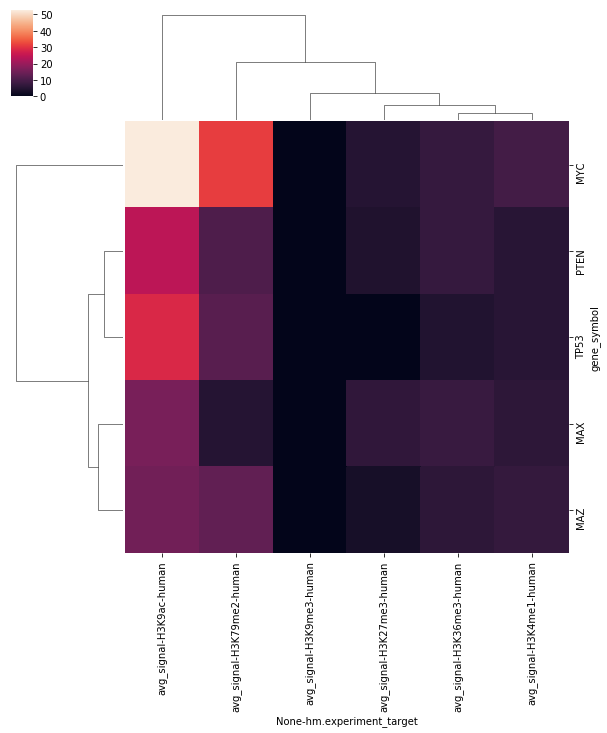

In [32]:
plt.figure()
sns.clustermap(mapping.to_matrix(index_regs=['gene_symbol'], 
                  columns_meta=['hm.experiment_target'], 
                  values_regs=['avg_signal'], fill_value=0, dropna=False))
plt.show()

### Performing Principal Component Analysis

In [52]:
from sklearn.decomposition import PCA
import pandas as pd

In [49]:
pca = PCA(n_components=2)

In [51]:
promoter_region_VS_hm = mapping.to_matrix(index_regs=['chr', 'start', 'stop', 'gene_symbol'], 
                                                 columns_meta=['hm.experiment_target'], 
                                                 values_regs=['avg_signal'], fill_value=0)

components = pca.fit_transform(promoter_region_VS_hm.values)


array([[ -4.65278476,  -1.43897483],
       [-14.57393849,  -0.82176556],
       [-10.92004762,   5.14151999],
       [ -0.32235881,  -4.06764647],
       [ 30.46912968,   1.18686687]])

In [55]:
PCA_regions = pd.DataFrame(index=promoter_region_VS_hm.index, columns=['1st_component', '2nd_component'], data=components).reset_index()

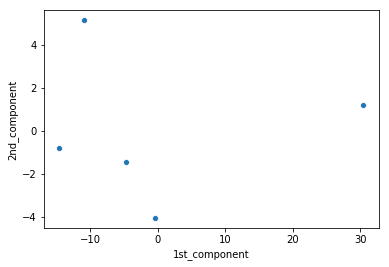

In [63]:
plt.figure()
sns.scatterplot(data=PCA_regions, x='1st_component', y='2nd_component')
plt.show()